In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import norm
import seaborn as sns
import warnings

import chainer
import chainer.functions as F
import chainer.links as L
import numpy as np
import math
from chainer import cuda, training, reporter, Variable
from chainer.training import trainer, extensions
from chainer import datasets
from chainer.dataset import convert
from chainer.dataset import iterator as iterator_module
from chainer import optimizer as optimizer_module
from chainer import iterators
from chainer import optimizers

warnings.filterwarnings('ignore')
%matplotlib inline
device = 0

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#bring in the six packs
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')
test_ID = df_test['Id']
print(df_train.shape, df_test.shape)

(1460, 81) (1459, 80)


In [3]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [5]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

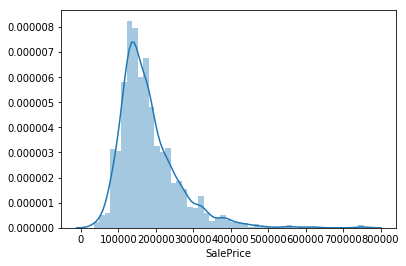

In [6]:
sns.distplot(df_train['SalePrice'])

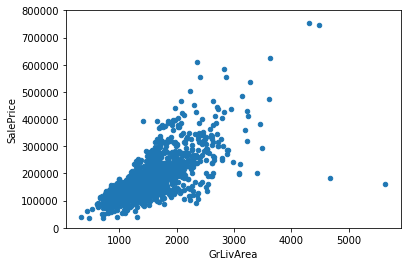

In [7]:
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

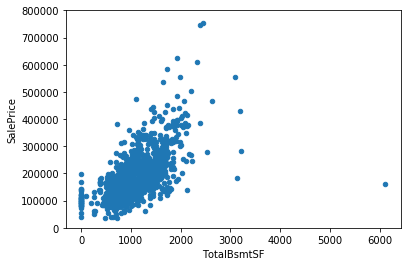

In [8]:
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [9]:
# string label to categorical values
from sklearn.preprocessing import LabelEncoder

for i in range(df_train.shape[1]):
    if df_train.iloc[:,i].dtypes == object:
        lbl = LabelEncoder()
        lbl.fit(list(df_train.iloc[:,i].values) + list(df_test.iloc[:,i].values))
        df_train.iloc[:,i] = lbl.transform(list(df_train.iloc[:,i].values))
        df_test.iloc[:,i] = lbl.transform(list(df_test.iloc[:,i].values))

In [10]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,2,3,3,0,...,0,3,4,4,0,2,2008,8,4,208500
1,2,20,3,80.0,9600,1,2,3,3,0,...,0,3,4,4,0,5,2007,8,4,181500
2,3,60,3,68.0,11250,1,2,0,3,0,...,0,3,4,4,0,9,2008,8,4,223500
3,4,70,3,60.0,9550,1,2,0,3,0,...,0,3,4,4,0,2,2006,8,0,140000
4,5,60,3,84.0,14260,1,2,0,3,0,...,0,3,4,4,0,12,2008,8,4,250000


In [11]:
corrmat = df_train.corr()
corrmat

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,1.000000,0.011156,-0.006096,-0.010601,-0.033226,0.008916,-0.001530,0.032122,-0.019659,0.013324,...,0.057044,-0.033928,-0.000399,0.037057,-0.006242,0.021172,0.000712,0.019773,-0.005806,-0.021917
MSSubClass,0.011156,1.000000,0.035900,-0.386347,-0.139781,-0.024969,-0.105995,0.119289,-0.002940,-0.022844,...,0.008283,-0.005221,0.086360,0.034859,-0.007683,-0.013585,-0.021407,0.012464,-0.024940,-0.084284
MSZoning,-0.006096,0.035900,1.000000,-0.111690,-0.034452,0.087654,-0.052039,0.061887,-0.017854,-0.001192,...,-0.003128,0.002882,-0.061289,0.000673,0.009293,-0.031496,-0.020628,0.097437,0.009494,-0.166872
LotFrontage,-0.010601,-0.386347,-0.111690,1.000000,0.426095,-0.040886,0.138101,-0.169641,-0.080757,NaN,...,0.206167,-0.195051,-0.040862,-0.006629,0.003368,0.011200,0.007450,-0.034559,0.063372,0.351799
LotArea,-0.033226,-0.139781,-0.034452,0.426095,1.000000,-0.197131,0.060105,-0.165315,-0.149083,0.010123,...,0.077672,-0.065167,0.036031,-0.103544,0.038068,0.001205,-0.014261,0.012292,0.034169,0.263843
Street,0.008916,-0.024969,0.087654,-0.040886,-0.197131,1.000000,-0.015720,-0.010224,0.115995,0.001682,...,0.004413,-0.004067,-0.029386,0.146712,-0.022733,0.003690,-0.025043,0.014339,0.006064,0.041036
Alley,-0.001530,-0.105995,-0.052039,0.138101,0.060105,-0.015720,1.000000,-0.120881,0.087372,0.006407,...,0.016810,-0.015492,0.021124,0.021856,0.001162,0.013094,0.020944,0.008205,0.035717,0.139868
LotShape,0.032122,0.119289,0.061887,-0.169641,-0.165315,-0.010224,-0.120881,1.000000,0.085434,-0.036101,...,-0.020051,0.018156,-0.045633,0.021062,-0.042061,-0.033455,0.036449,-0.000911,-0.038118,-0.255580
LandContour,-0.019659,-0.002940,-0.017854,-0.080757,-0.149083,0.115995,0.087372,0.085434,1.000000,0.008238,...,-0.013098,0.000731,-0.043773,-0.017147,0.020912,-0.011599,0.020507,-0.025754,0.033809,0.015453
Utilities,0.013324,-0.022844,-0.001192,NaN,0.010123,0.001682,0.006407,-0.036101,0.008238,1.000000,...,-0.001798,0.001657,0.011976,0.005016,-0.002296,-0.051552,0.023353,-0.126770,-0.089701,-0.014314


In [12]:
cols = corrmat.nlargest(11, 'SalePrice')['SalePrice'].index
print(cols)
corrmat[cols[10]]['SalePrice']

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt',
       'YearRemodAdd'],
      dtype='object')


0.5071009671113867

In [13]:
# sns.set()
# sns.pairplot(df_train, size = 2.5)
# plt.show()

In [14]:
df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,3,313.0,63887,1,2,2,0,0,...,480,2,4,4,0,1,2008,6,5,160000
523,524,60,3,130.0,40094,1,2,0,0,0,...,0,3,4,4,0,10,2007,6,5,184750


In [15]:
df_train.sort_values(by = 'TotalBsmtSF', ascending = False)[:1]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,3,313.0,63887,1,2,2,0,0,...,480,2,4,4,0,1,2008,6,5,160000


In [16]:
df_train.sort_values(by = '1stFlrSF', ascending = False)[:1]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,3,313.0,63887,1,2,2,0,0,...,480,2,4,4,0,1,2008,6,5,160000


In [17]:
df_train = df_train.drop(index = df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(index = df_train[df_train['Id'] == 524].index)

In [18]:
df_train = df_train.fillna(df_train.median())
df_test = df_test.fillna(df_train.median())

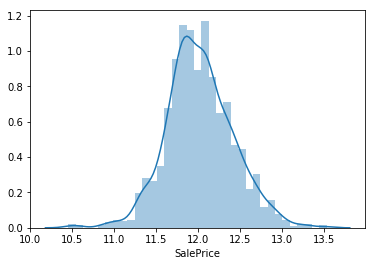

In [19]:
df_train['SalePrice'] = np.log(df_train['SalePrice'])
sns.distplot(df_train['SalePrice'])

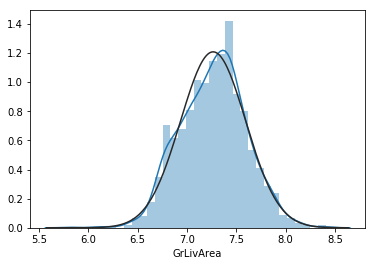

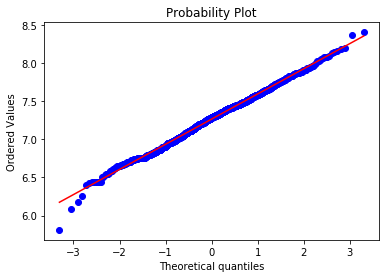

In [20]:
df_train['GrLivArea'] = np.log(df_train['GrLivArea'])
df_test['GrLivArea'] = np.log(df_test['GrLivArea'])
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

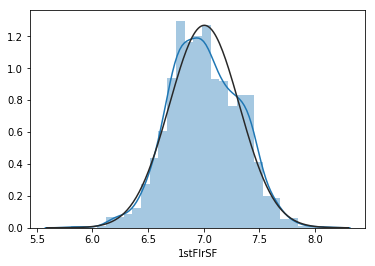

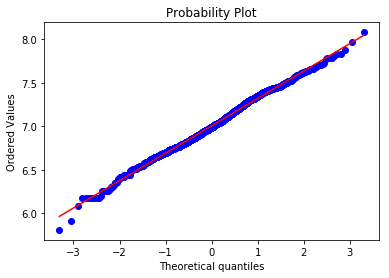

In [21]:
df_train['1stFlrSF'] = np.log(df_train['1stFlrSF'])
df_test['1stFlrSF'] = np.log(df_test['1stFlrSF'])
sns.distplot(df_train['1stFlrSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['1stFlrSF'], plot=plt)

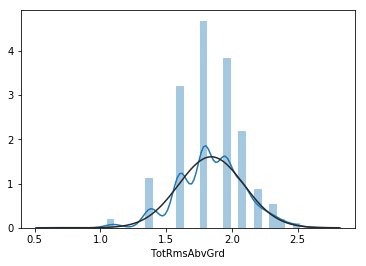

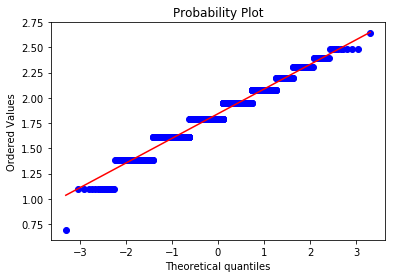

In [22]:
df_train['TotRmsAbvGrd'] = np.log(df_train['TotRmsAbvGrd'])
df_test['TotRmsAbvGrd'] = np.log(df_test['TotRmsAbvGrd'])
sns.distplot(df_train['TotRmsAbvGrd'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['TotRmsAbvGrd'], plot=plt)

In [23]:
df_train = df_train[cols]
df_test = df_test[cols[1:]]
df_train = df_train.as_matrix()
df_test = df_test.as_matrix()
print(df_train.shape, df_test.shape)
train_x = df_train[:, 1:].astype(np.float32)
train_t = df_train[:, :1].astype(np.float32)

test_x = df_test.astype(np.float32)
thresh_hold = int(train_x.shape[0]*0.8)
train = datasets.TupleDataset(train_x[:thresh_hold], train_t[:thresh_hold])
valid = datasets.TupleDataset(train_x[thresh_hold:], train_t[thresh_hold:])


(1458, 11) (1459, 10)


In [24]:
class LinearBlock(chainer.Chain):

    def __init__(self, inp=None, mid=256, drop=False, bn = False):
        w = chainer.initializers.HeNormal()
        super(LinearBlock, self).__init__()
        with self.init_scope():
            self.fc = L.Linear(inp, mid, initialW=w)
            self.bnorm = L.BatchNormalization(mid)
        self.drop = drop
        self.bn = bn

    def __call__(self, x):
        h = self.fc(x)
        if self.bn:
            h = self.bnorm(h)
        h = F.relu(h)
        if self.drop:
            h = F.dropout(h)
        return h
    
class MyNetwork(chainer.Chain):
    def __init__(self, mid):
        super(MyNetwork, self).__init__()
        w = chainer.initializers.HeNormal()
        
        with self.init_scope():
            self.l1 = LinearBlock(mid = mid, bn = True)
            self.l2 = LinearBlock(mid = mid*2, bn = True)
            
            self.last = L.Linear(None, 1, initialW=w)
            
    def __call__(self, x):
        return self.forward(x)
    
    def forward(self, x):
        h = self.last(self.l2(self.l1(x)))
        #h = F.concat((h1, h2, h3, h4), axis = -1)
        #h = h1
        #h = F.mean(h, axis=-1, keepdims=True)
        #h  = self.concat(F.relu(h))
        return h
    
#     def predict(self, x):
#         with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
#             y_pred = F.mean(self.forward(x), axis=-1, keepdims=True)
#         return y_pred
            

In [25]:
import chainer
import numpy as np
import six
import chainer.functions as F
import chainer.links as L
from chainer import training, cuda, reporter
from chainer.dataset import convert
from chainer.dataset import iterator as iterator_module

class MyUpdater(training.StandardUpdater):
    def __init__(self, iterator, net_dict, opt,
        converter=convert.concat_examples, device=0):
        if isinstance(iterator, iterator_module.Iterator):
            iterator = {'main': iterator}
        self._iterators = iterator
        self.net_dict = net_dict
        self._optimizers = opt
        self.converter = converter
        self.device = device
        self.iteration = 0

    def update_core(self):
        iterator = self._iterators['main'].next()
        #入力データ
        input = self.converter(iterator, self.device)
        xp = np if int(self.device) == -1 else cuda.cupy
        x_batch = xp.array(input[0]) #入力データ
        t_batch = xp.array(input[1]) #教師データ
        #loss
        loss_dic = {}
        for i, net in enumerate(self.net_dict.values()):
            loss = F.mean_squared_error(net(x_batch), t_batch)
            loss_dic[str(i)] = loss
            
        #計算開始
        for name, optimizer in six.iteritems(self._optimizers):
            optimizer.target.cleargrads()
            
        for name, loss in six.iteritems(loss_dic):
            loss.backward()

        for name, optimizer in six.iteritems(self._optimizers):
            optimizer.update()
        report_dict = {}
        for i, loss in enumerate(loss_dic.values()):
            report_dict['main/loss'+str(i)] =  loss
        reporter.report(report_dict)

        
import chainer
import copy
import numpy as np
import chainer.functions as F
import chainer.links as L
from chainer import training, cuda, reporter
from chainer.training import extensions
from chainer.dataset import convert
from chainer.dataset import iterator as iterator_module

class MyEvaluator(extensions.Evaluator):
    def __init__(self, iterator, net_dict,
        converter=convert.concat_examples, device=0, eval_hook=None,
        eval_func=None):
        if isinstance(iterator, iterator_module.Iterator):
            iterator = {'main': iterator}
        self._iterators = iterator
        self._targets = net_dict
        self.converter = converter
        self.device = device
        self.eval_hook = eval_hook

    def evaluate(self):
        iterator = self._iterators['main']
        #入力データ
        xp = np if int(self.device) == -1 else cuda.cupy
        it = copy.copy(iterator)
        summary = reporter.DictSummary()
        for batch in it:
            observation = {}
            with reporter.report_scope(observation):
                input = self.converter(batch, self.device)
                x_batch = xp.array(input[0]) #入力データ
                t_batch = xp.array(input[1]) #教師データ
                #loss
                loss = 0
                #計算開始
                with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
                    for i, net in enumerate(self._targets.values()):
                        loss = loss + F.mean_squared_error(net(x_batch), t_batch)
                    loss = loss/len(self._targets.values())
                observation['val/main/loss'] = loss
            summary.add(observation)
        return summary.compute_mean()

In [26]:
batch_size = 128
train_iter = iterators.SerialIterator(train, batch_size)
valid_iter  = iterators.SerialIterator(valid, batch_size, repeat=False, shuffle=False)
test_iter = iterators.SerialIterator(test_x, batch_size, False, False)

In [27]:
net1 = MyNetwork(mid = 8)
net2 = MyNetwork(mid = 16)
net3 = MyNetwork(mid = 32)
net4 = MyNetwork(mid = 64)
net_dict = {'0': net1, '1': net2, '2': net3, '3': net4}
optimizer_dict= {}
for i, net in enumerate(net_dict.values()):
        net.to_gpu(device)
        optimizer = optimizers.Adam(alpha=0.0002, beta1=0.9, beta2=0.999).setup(net)
        optimizer.add_hook(chainer.optimizer.WeightDecay(0.0001))
        optimizer_dict[str(i)] = optimizer

In [28]:
updater = MyUpdater(train_iter, net_dict, optimizer_dict, device=device)
max_epoch = 5000
trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='results')
trainer.extend(extensions.LogReport())
print_report_list = []
for i, net in enumerate(net_dict.values()):
    trainer.extend(extensions.snapshot_object(net, filename='net'+str(i)+'_epoch-{.updater.epoch}'), trigger=(100,'epoch'))
    print_report_list.append('main/loss'+str(i))
trainer.extend(MyEvaluator(valid_iter, net_dict, device=device), name='val')
trainer.extend(extensions.PrintReport(['epoch', print_report_list[0], print_report_list[1], print_report_list[2], print_report_list[3],  'val/main/loss', 'elapsed_time']))
trainer.extend(extensions.PlotReport([print_report_list[0], print_report_list[1], print_report_list[2], print_report_list[3], 'val/main/loss'], x_key='epoch', file_name='loss.png'))
#trainer.extend(extensions.dump_graph(print_report_list[0], print_report_list[1], print_report_list[2], print_report_list[3],))

In [ ]:
trainer.run()

In [29]:
infer_net1 = MyNetwork(mid = 8)
infer_net2 = MyNetwork(mid = 16)
infer_net3 = MyNetwork(mid = 32)
infer_net4 = MyNetwork(mid = 64)
infer_net_dict = {'0': net1, '1': net2, '2': net3, '3': net4}
from chainer import serializers
for i, infer_net in enumerate(infer_net_dict.values()):
    serializers.load_npz('results/'+'net'+str(i)+'_epoch-5000', infer_net, path='')
    if device >= 0:
        infer_net.to_gpu(0)

In [30]:
t_x = test_x
t_x = infer_net.xp.asarray(t_x)
y_pred = 0
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    for i, infer_net in enumerate(infer_net_dict.values()):
        y_pred = y_pred + infer_net(t_x).array
    y = y_pred / len(infer_net_dict.values())

In [31]:
print(y.max(), y.min(), y.mean())

15.189697 10.679453 11.977361


In [32]:
print(train_t.max(), train_t.min(), train_t.mean())

13.534473 10.460242 12.024008


In [33]:
y_pred = np.exp(chainer.cuda.to_cpu(y))

In [34]:
submission = pd.DataFrame({
    "Id": test_ID,
    "SalePrice": y_pred.reshape((1459))
})

In [35]:
test_ID.shape
y_pred.shape

(1459, 1)

In [36]:
submission.to_csv('houseprice.csv', index=False)